In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

### Define likelihood

### Render images and set up experiment

/opt/conda/envs/b3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]


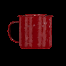

In [3]:
image_width, image_height, fx, fy, cx, cy, near, far = (
    66,
    66,
    200.0,
    200.0,
    66.0/2,
    66.0/2,
    0.01,
    10.0,
)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
vertices = jnp.array(mesh.vertices)
vertices = vertices - jnp.mean(vertices, axis=0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
print("Vertices dimensions :", vertices.max(0) - vertices.min(0))

key = jax.random.PRNGKey(0)

camera_pose = Pose.from_position_and_target(
    jnp.array([0.5, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])
)

cp_to_pose = lambda cp: Pose(
    jnp.array([cp[0], cp[1], 0.0]),
    b3d.Rot.from_rotvec(jnp.array([0.0, 0.0, cp[2]])).as_quat(),
)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(vertices, faces, vertex_colors)

cps_to_test = [
    jnp.array([0.0, 0.0, jnp.pi]),  # Hidden
    jnp.array([0.0, 0.0, -jnp.pi / 2]),  # Side
    jnp.array([0.0, 0.0, 0.0]),  # Front
    jnp.array([0.0, 0.0, +jnp.pi / 2]),  # Side
]

text_index = 1

gt_cp = cps_to_test[text_index]

object_pose = cp_to_pose(gt_cp)

gt_img, gt_depth = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
b3d.get_rgb_pil_image(gt_img)

In [4]:

delta_cps = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-jnp.pi, jnp.pi, 71),
    ),
    axis=-1,
).reshape(-1, 3)
cp_delta_poses = jax.vmap(cp_to_pose)(delta_cps)

test_poses = object_pose @ cp_delta_poses

rgb_ims, depth_ims = renderer.render_attribute_many(
    (camera_pose.inv() @ test_poses)[:,None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)



2024-06-29 03:29:42.058416: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 8.26GiB (8873555884 bytes) by rematerialization; only reduced to 8.86GiB (9510855568 bytes), down from 8.86GiB (9510855568 bytes) originally


RuntimeError: Cuda error: 9[cudaLaunchKernel((void*)InterpolateFwdKernel, gridSize, blockSize, args, 0, stream);]
Exception raised from jax_interpolate_fwd at /home/nishadgothoskar/b3d/b3d/renderer/nvdiffrast/jax/jax_interpolate.cpp:129 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f88d188fd87 in /opt/conda/envs/b3d/lib/python3.12/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7f88d184075f in /opt/conda/envs/b3d/lib/python3.12/site-packages/torch/lib/libc10.so)
frame #2: jax_interpolate_fwd(CUstream_st*, void**, char const*, unsigned long) + 0x27c (0x7f8a57d527b4 in /home/nishadgothoskar/.cache/torch_extensions/py312_cu121/nvdiffrast_plugin_differentiable_modified_gl/nvdiffrast_plugin_differentiable_modified_gl.so)
frame #3: <unknown function> + 0xe29d0f (0x7f8a0774ad0f in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #4: <unknown function> + 0xe2a515 (0x7f8a0774b515 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #5: <unknown function> + 0x16821e3 (0x7f8a07fa31e3 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #6: <unknown function> + 0x167f8d9 (0x7f8a07fa08d9 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #7: <unknown function> + 0x167dfdd (0x7f8a07f9efdd in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #8: <unknown function> + 0x167d94f (0x7f8a07f9e94f in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #9: <unknown function> + 0x388b246 (0x7f8a0a1ac246 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #10: <unknown function> + 0x500085 (0x7f8a06e21085 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #11: <unknown function> + 0x500a28 (0x7f8a06e21a28 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #12: <unknown function> + 0x4a2eb8 (0x7f8a06dc3eb8 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #13: <unknown function> + 0x4a5877 (0x7f8a06dc6877 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #14: <unknown function> + 0x4a7ed0 (0x7f8a06dc8ed0 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #15: <unknown function> + 0x41fa1f (0x7f8a06d40a1f in /opt/conda/envs/b3d/lib/python3.12/site-packages/jax_plugins/xla_cuda12/xla_cuda_plugin.so)
frame #16: <unknown function> + 0x6a51b8 (0x7f8a2bfbf1b8 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #17: <unknown function> + 0x56a36bd (0x7f8a30fbd6bd in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #18: <unknown function> + 0x4ca3858 (0x7f8a305bd858 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #19: <unknown function> + 0x4ca4dcc (0x7f8a305bedcc in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #20: <unknown function> + 0x54bb15 (0x7f8a2be65b15 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #21: <unknown function> + 0x54b94d (0x7f8a2be6594d in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #22: <unknown function> + 0x693df1d (0x7f8a32257f1d in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #23: PyObject_Vectorcall + 0x4f (0x55c52fbf6c9f in /opt/conda/envs/b3d/bin/python3.12)
frame #24: <unknown function> + 0x113f20 (0x55c52fae8f20 in /opt/conda/envs/b3d/bin/python3.12)
frame #25: _PyObject_FastCallDictTstate + 0x1fa (0x55c52fbe471a in /opt/conda/envs/b3d/bin/python3.12)
frame #26: _PyObject_Call_Prepend + 0x69 (0x55c52fc10099 in /opt/conda/envs/b3d/bin/python3.12)
frame #27: <unknown function> + 0x310913 (0x55c52fce5913 in /opt/conda/envs/b3d/bin/python3.12)
frame #28: _PyObject_Call + 0xb5 (0x55c52fc12ae5 in /opt/conda/envs/b3d/bin/python3.12)
frame #29: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #30: PyObject_Vectorcall + 0x4f (0x55c52fbf6c9f in /opt/conda/envs/b3d/bin/python3.12)
frame #31: <unknown function> + 0x5aa00e (0x7f8a2bec400e in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #32: <unknown function> + 0x5a8553 (0x7f8a2bec2553 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #33: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #34: <unknown function> + 0x25a6dc (0x55c52fc2f6dc in /opt/conda/envs/b3d/bin/python3.12)
frame #35: <unknown function> + 0x25a25d (0x55c52fc2f25d in /opt/conda/envs/b3d/bin/python3.12)
frame #36: _PyObject_Call + 0x123 (0x55c52fc12b53 in /opt/conda/envs/b3d/bin/python3.12)
frame #37: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #38: PyObject_Vectorcall + 0x4f (0x55c52fbf6c9f in /opt/conda/envs/b3d/bin/python3.12)
frame #39: <unknown function> + 0x5aa00e (0x7f8a2bec400e in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #40: <unknown function> + 0x5a8553 (0x7f8a2bec2553 in /opt/conda/envs/b3d/lib/python3.12/site-packages/jaxlib/xla_extension.so)
frame #41: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #42: <unknown function> + 0x207014 (0x55c52fbdc014 in /opt/conda/envs/b3d/bin/python3.12)
frame #43: <unknown function> + 0x31324f (0x55c52fce824f in /opt/conda/envs/b3d/bin/python3.12)
frame #44: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #45: PyEval_EvalCode + 0xae (0x55c52fc9c6fe in /opt/conda/envs/b3d/bin/python3.12)
frame #46: <unknown function> + 0x2e29cd (0x55c52fcb79cd in /opt/conda/envs/b3d/bin/python3.12)
frame #47: <unknown function> + 0x1157df (0x55c52faea7df in /opt/conda/envs/b3d/bin/python3.12)
frame #48: <unknown function> + 0x2dde72 (0x55c52fcb2e72 in /opt/conda/envs/b3d/bin/python3.12)
frame #49: <unknown function> + 0x332477 (0x55c52fd07477 in /opt/conda/envs/b3d/bin/python3.12)
frame #50: <unknown function> + 0x11618e (0x55c52faeb18e in /opt/conda/envs/b3d/bin/python3.12)
frame #51: <unknown function> + 0x25a6dc (0x55c52fc2f6dc in /opt/conda/envs/b3d/bin/python3.12)
frame #52: <unknown function> + 0x25a25d (0x55c52fc2f25d in /opt/conda/envs/b3d/bin/python3.12)
frame #53: _PyObject_Call + 0x123 (0x55c52fc12b53 in /opt/conda/envs/b3d/bin/python3.12)
frame #54: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #55: <unknown function> + 0x2dde72 (0x55c52fcb2e72 in /opt/conda/envs/b3d/bin/python3.12)
frame #56: <unknown function> + 0x81e6 (0x7f8a826331e6 in /opt/conda/envs/b3d/lib/python3.12/lib-dynload/_asyncio.cpython-312-x86_64-linux-gnu.so)
frame #57: <unknown function> + 0x899a (0x7f8a8263399a in /opt/conda/envs/b3d/lib/python3.12/lib-dynload/_asyncio.cpython-312-x86_64-linux-gnu.so)
frame #58: <unknown function> + 0x22bbba (0x55c52fc00bba in /opt/conda/envs/b3d/bin/python3.12)
frame #59: <unknown function> + 0x35d0fc (0x55c52fd320fc in /opt/conda/envs/b3d/bin/python3.12)
frame #60: <unknown function> + 0x1cab2c (0x55c52fb9fb2c in /opt/conda/envs/b3d/bin/python3.12)
frame #61: <unknown function> + 0x221f16 (0x55c52fbf6f16 in /opt/conda/envs/b3d/bin/python3.12)
frame #62: <unknown function> + 0x114c54 (0x55c52fae9c54 in /opt/conda/envs/b3d/bin/python3.12)
frame #63: PyEval_EvalCode + 0xae (0x55c52fc9c6fe in /opt/conda/envs/b3d/bin/python3.12)


In [ ]:

def get_rgb_depth_inliers_from_observed_rendered_args(observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args):
    observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
    error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (error < model_args.color_tolerance) * valid_data_mask
    depth_inliers = (jnp.abs(observed_depth - rendered_depth) < model_args.depth_tolerance) * valid_data_mask
    inliers = color_inliers * depth_inliers
    outliers = jnp.logical_not(inliers) * valid_data_mask
    undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)
    return (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask)

def logpdf(observed_rgb, observed_depth, rendered_rgb, rendered_depth, fx, fy, height, width, near, far, model_args):

    inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask = get_rgb_depth_inliers_from_observed_rendered_args(
        observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args
    )

    inlier_score = model_args.inlier_score
    outlier_prob = model_args.outlier_prob
    multiplier = model_args.color_multiplier

    corrected_depth = rendered_depth + (rendered_depth == 0.0) * far
    areas = (corrected_depth / fx) * (corrected_depth / fy)

    final_log_score =  jnp.log(
        # This is leaving out a 1/A (which does depend upon the scene)
        inlier_score * jnp.sum(inliers * areas) +
        1.0 * jnp.sum(undecided * areas)  +
        outlier_prob * jnp.sum(outliers * areas)
    ) * multiplier
    # final_log_score =  jnp.log(inlier_contribution + outlier_contribution_teleporation + outlier_contribution_not_teleportation) * model_args.color_multiplier
    return {'log_score':final_log_score}
            # ,
            # 'inlier_score': inlier_contribution,
            # 'outlier_teleport_score': outlier_contribution_teleporation, 
            # 'outlier_no_teleport_score': outlier_contribution_not_teleportation}

logpdfs = jax.vmap(logpdf, (None, None, 0, 0, None, None, None, None, None, None, None))

In [ ]:
color_error, depth_error = (60.0, 0.02)
inlier_score, outlier_prob = (5.0, 0.00001)
color_multiplier, depth_multiplier = (10000.0, 500.0)
model_args = b3d.bayes3d.ModelArgs(
    color_error,
    depth_error,
    inlier_score,
    outlier_prob,
    color_multiplier,
    depth_multiplier,
)

scores_dict = logpdfs(gt_img, gt_depth, rgb_ims, depth_ims, renderer.fx,renderer.fy, renderer.height, renderer.width, renderer.near, renderer.far, model_args)
scores = scores_dict['log_score']

samples = jax.random.categorical(key, scores, shape=(50,))
print(samples)

In [ ]:
rr.log("observed_depth_no_background", rr.DepthImage(gt_depth))
gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape)*renderer.far, gt_depth)


In [14]:


]
    

    rr.log("observed_depth_no_background", rr.DepthImage(gt_depth))
    gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape)*renderer.far, gt_depth)

    
    scores = scores_dict['log_score']
    inlier_scores = scores_dict['inlier_score']
    outlier_tele_scores = scores_dict['outlier_teleport_score']
    outlier_no_tele_scores = scores_dict['outlier_no_teleport_score']


    samples = jax.random.categorical(key, scores, shape=(50,))
    print("GT Contact Parameter :", gt_cp)

    samples_deg_range = jnp.rad2deg(
        (
            jnp.max(delta_cps[samples], axis=0)
            - jnp.min(delta_cps[samples], axis=0)
        )[2]
    )

    print("Sampled Angle Range:", samples_deg_range)

    alternate_camera_pose = Pose.from_position_and_target(
        jnp.array([0.01, 0.000, 0.9]), object_pose.pos
    )
    alternate_view_images, _ = renderer.render_attribute_many(
        (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )

    
    print(samples_deg_range, sampled_degree_range_bounds[text_index][0], sampled_degree_range_bounds[text_index][1])
    print(cp_delta_poses[jnp.argmax(scores)])


/opt/conda/envs/b3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]
GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 149.14285
149.14285 50.0 80.0
Pose(position=Array([0., 0., 0.], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))


Text(0, 0.5, 'score')

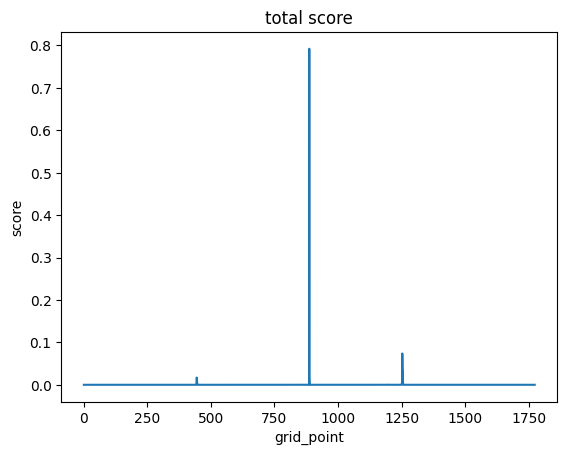

In [15]:
plt.plot(b3d.normalize_log_scores(scores))
plt.title('total score')
plt.xlabel('grid_point')
plt.ylabel('score')

Text(0, 0.5, 'score')

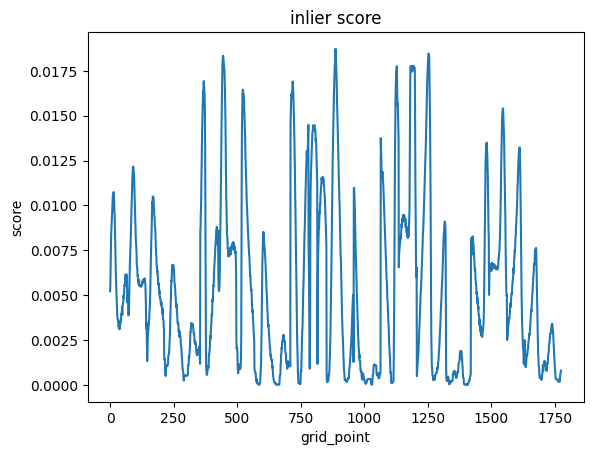

In [8]:
plt.plot(inlier_scores)
plt.title('inlier score')
plt.xlabel('grid_point')
plt.ylabel('score')

Text(0, 0.5, 'score')

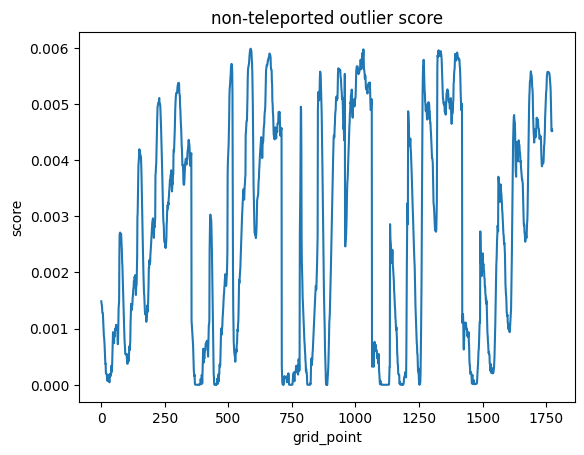

In [9]:
plt.plot(outlier_no_tele_scores)
plt.title('non-teleported outlier score')
plt.xlabel('grid_point')
plt.ylabel('score')

Text(0, 0.5, 'score')

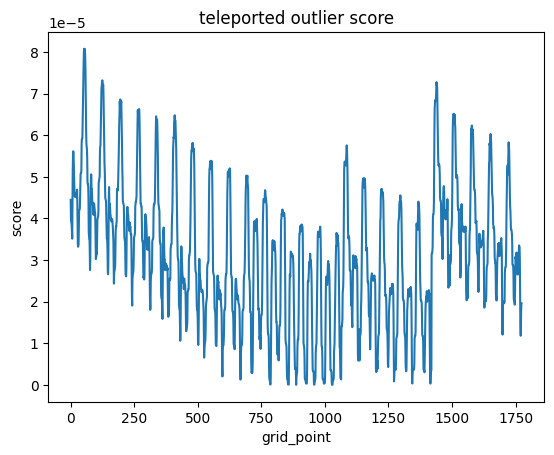

In [10]:
plt.plot(outlier_tele_scores)
plt.title('teleported outlier score')
plt.xlabel('grid_point')
plt.ylabel('score')

### Best-scoring example

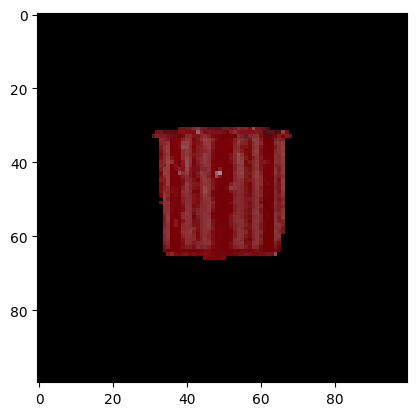

In [16]:
# show sample
plt.imshow((rgb_ims[jnp.argmax(scores)] + gt_img)/2)

In [31]:
# generate inlier/outlier maps

In [32]:
inliers, _, _, teleport_outliers, nonteleport_outliers, _ = get_rgb_depth_inliers_from_observed_rendered_args(gt_img, rgb_ims[jnp.argmax(scores)], gt_depth, depth_ims[jnp.argmax(scores)],  model_args)

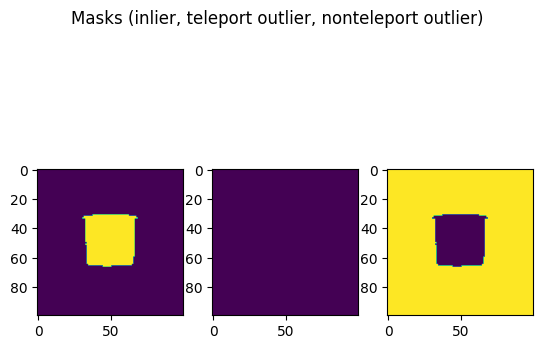

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Masks (inlier, teleport outlier, nonteleport outlier)')
ax1.imshow(inliers)
ax2.imshow(teleport_outliers)
ax3.imshow(nonteleport_outliers)

In [34]:
# make gif if best-scoring samples
b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(rgb_ims[ind]*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
                              for ind in jnp.argsort(scores)[::-1][:25]], 'samples.gif'
)

In [35]:
jnp.argsort(scores)[::-1][:10]

Array([ 887, 1253, 1254, 1255,  888,  444,  445, 1252,  446,  443], dtype=int32)